In [ ]:
# Large Language Models - Transformers - 2
# original paper:  Vawani et al. Attention is all you need. 2017.
# https://arxiv.org/pdf/1706.03762.pdf

# implementation sources: 
# https://buomsoo-kim.github.io/attention/2020/01/12/Attention-mechanism-3.md/
# https://buomsoo-kim.github.io/attention/2020/04/19/Attention-mechanism-17.md/
# https://buomsoo-kim.github.io/attention/2020/04/21/Attention-mechanism-19.md/

# video overview
# https://www.youtube.com/watch?v=iDulhoQ2pro&ab_channel=YannicKilcher


"The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions entirely."

++ While LSTM-based decoders are autoregressive by nature, Transformers are not. Instead, all predictions are generated at once based on the real target tokens ++



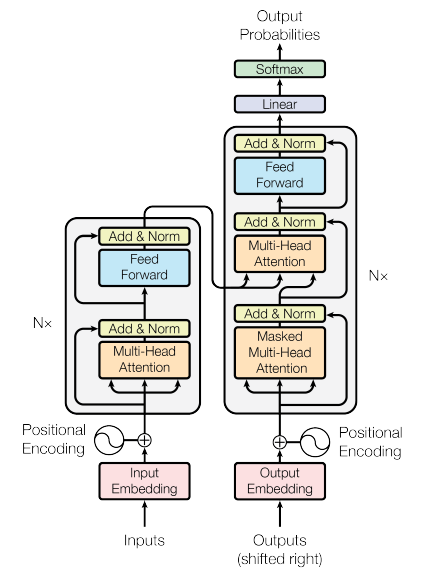

"An attention function can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
of the values, where the weight assigned to each value is computed by a compatibility function of the
query with the corresponding key."


"Instead of performing a single attention function with dmodel-dimensional keys, values and queries,
we found it beneficial to linearly project the queries, keys and values h times with different, learned
linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of
queries, keys and values we then perform the attention function in parallel, yielding dv-dimensional
output values. These are concatenated and once again projected, resulting in the final values."

In [1]:
!wget https://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip

with open("deu.txt") as f:
  sentences = f.readlines()

--2023-05-02 21:21:18--  https://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9822750 (9.4M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   9.37M  4.90MB/s    in 1.9s    

2023-05-02 21:21:21 (4.90 MB/s) - ‘deu-eng.zip’ saved [9822750/9822750]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [2]:
print(len(sentences))
print(sentences[0:5])

261499
['Go.\tGeh.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)\n', 'Hi.\tHallo!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)\n', 'Hi.\tGrüß Gott!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)\n', 'Run!\tLauf!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)\n', 'Run.\tLauf!\tCC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #941078 (Fingerhut)\n']


In [3]:
import re
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler

In [11]:
## source: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [4]:
NUM_INSTANCES = 30000     # start with 10000
MAX_SENT_LEN = 10

eng_sentences, deu_sentences = [], []
eng_words, deu_words = set(), set()
for i in tqdm(range(NUM_INSTANCES)):
  rand_idx = np.random.randint(len(sentences))
  # find only letters in sentences
  eng_sent, deu_sent = ["<sos>"], ["<sos>"]
  eng_sent += re.findall(r"\w+", sentences[rand_idx].split("\t")[0]) 
  deu_sent += re.findall(r"\w+", sentences[rand_idx].split("\t")[1])

  # change to lowercase
  eng_sent = [x.lower() for x in eng_sent]
  deu_sent = [x.lower() for x in deu_sent]
  eng_sent.append("<eos>")
  deu_sent.append("<eos>")

  if len(eng_sent) >= MAX_SENT_LEN:
    eng_sent = eng_sent[:MAX_SENT_LEN]
  else:
    for _ in range(MAX_SENT_LEN - len(eng_sent)):
      eng_sent.append("<pad>")

  if len(deu_sent) >= MAX_SENT_LEN:
    deu_sent = deu_sent[:MAX_SENT_LEN]
  else:
    for _ in range(MAX_SENT_LEN - len(deu_sent)):
      deu_sent.append("<pad>")

  # add parsed sentences
  eng_sentences.append(eng_sent)
  deu_sentences.append(deu_sent)

  # update unique words
  eng_words.update(eng_sent)
  deu_words.update(deu_sent)

eng_words, deu_words = list(eng_words), list(deu_words)

# encode each token into index
for i in tqdm(range(len(eng_sentences))):
  eng_sentences[i] = [eng_words.index(x) for x in eng_sentences[i]]
  deu_sentences[i] = [deu_words.index(x) for x in deu_sentences[i]]

idx = 10
print(eng_sentences[idx])
print([eng_words[x] for x in eng_sentences[idx]])
print(deu_sentences[idx])
print([deu_words[x] for x in deu_sentences[idx]])

100%|██████████| 30000/30000 [01:17<00:00, 386.58it/s]

[3607, 5852, 1746, 1582, 2149, 3143, 1579, 1579, 1579, 1579]
['<sos>', 'tom', 'never', 'hurt', 'me', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>']
[6140, 9937, 11138, 1628, 1327, 394, 10027, 5392, 2700, 2700]
['<sos>', 'tom', 'hat', 'mir', 'nie', 'weh', 'getan', '<eos>', '<pad>', '<pad>']


In [5]:
ENG_VOCAB_SIZE = len(eng_words)
DEU_VOCAB_SIZE = len(deu_words)

print(ENG_VOCAB_SIZE)
print(DEU_VOCAB_SIZE)

NUM_EPOCHS = 50
HIDDEN_SIZE = 16
EMBEDDING_DIM = 30
BATCH_SIZE = 128
NUM_HEADS = 2
NUM_LAYERS = 3
LEARNING_RATE = 1e-2
DROPOUT = .3
DEVICE = torch.device('cuda') 

7355
12475


In [6]:
class MTDataset(torch.utils.data.Dataset):
  def __init__(self):
    # import and initialize dataset    
    self.source = np.array(eng_sentences, dtype = int)
    self.target = np.array(deu_sentences, dtype = int)
    
  def __getitem__(self, idx):
    # get item by index
    return self.source[idx], self.target[idx]
  
  def __len__(self):
    # returns length of data
    return len(self.source)

np.random.seed(777)   # for reproducibility
dataset = MTDataset()
NUM_INSTANCES = len(dataset)
TEST_RATIO = 0.3
TEST_SIZE = int(NUM_INSTANCES * 0.3)

indices = list(range(NUM_INSTANCES))

test_idx = np.random.choice(indices, size = TEST_SIZE, replace = False)
train_idx = list(set(indices) - set(test_idx))
train_sampler, test_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = test_sampler)

In [ ]:
for i, (x, y) in enumerate(train_loader):
  print(x,y)

In [9]:
class TransformerNet(nn.Module):
  def __init__(self, num_src_vocab, num_tgt_vocab, embedding_dim, hidden_size, nheads, n_layers, max_src_len, max_tgt_len, dropout):
    super(TransformerNet, self).__init__()
    # embedding layers
    self.enc_embedding = nn.Embedding(num_src_vocab, embedding_dim)
    self.dec_embedding = nn.Embedding(num_tgt_vocab, embedding_dim)

    # positional encoding layers
    self.enc_pe = PositionalEncoding(embedding_dim, max_len = max_src_len)
    self.dec_pe = PositionalEncoding(embedding_dim, max_len = max_tgt_len)

    # encoder/decoder layers
    enc_layer = nn.TransformerEncoderLayer(embedding_dim, nheads, hidden_size, dropout)
    dec_layer = nn.TransformerDecoderLayer(embedding_dim, nheads, hidden_size, dropout)
    self.encoder = nn.TransformerEncoder(enc_layer, num_layers = n_layers)
    self.decoder = nn.TransformerDecoder(dec_layer, num_layers = n_layers)

    # final dense layer
    self.dense = nn.Linear(embedding_dim, num_tgt_vocab)
    self.log_softmax = nn.LogSoftmax()

  def forward(self, src, tgt):
    src, tgt = self.enc_embedding(src).permute(1, 0, 2), self.dec_embedding(tgt).permute(1, 0, 2)
    src, tgt = self.enc_pe(src), self.dec_pe(tgt)
    memory = self.encoder(src)
    transformer_out = self.decoder(tgt, memory)
    final_out = self.dense(transformer_out)
    return self.log_softmax(final_out)

In [12]:
model = TransformerNet(ENG_VOCAB_SIZE, DEU_VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE, NUM_HEADS, NUM_LAYERS, MAX_SENT_LEN, MAX_SENT_LEN, DROPOUT).to(DEVICE)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [13]:
%%time
import matplotlib.pyplot as plt
interval = 100
loss_trace = []
current_loss = 0

for epoch in tqdm(range(NUM_EPOCHS)):
  current_loss = 0
  for i, (x, y) in enumerate(train_loader):
    x, y  = x.to(DEVICE), y.to(DEVICE)
    outputs = model(x, y)
    loss = criterion(outputs.permute(1, 2, 0), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if(i % interval == 0):
      print("\nHere is the current loss: ", loss.item())
  loss_trace.append(current_loss)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-9-a773fbcc039d>:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.log_softmax(final_out)



Here is the current loss:  2.2477450370788574

Here is the current loss:  0.40303701162338257


  2%|▏         | 1/50 [00:04<03:36,  4.42s/it]


Here is the current loss:  0.2573401629924774

Here is the current loss:  0.2701070010662079


  4%|▍         | 2/50 [00:07<02:57,  3.70s/it]


Here is the current loss:  0.22422440350055695

Here is the current loss:  0.22513210773468018


  6%|▌         | 3/50 [00:10<02:45,  3.53s/it]


Here is the current loss:  0.26200294494628906

Here is the current loss:  0.2567487061023712


  8%|▊         | 4/50 [00:14<02:47,  3.64s/it]


Here is the current loss:  0.2966424822807312

Here is the current loss:  0.24477574229240417


 10%|█         | 5/50 [00:18<02:38,  3.51s/it]


Here is the current loss:  0.2198476493358612

Here is the current loss:  0.2672550082206726


 12%|█▏        | 6/50 [00:21<02:29,  3.40s/it]


Here is the current loss:  0.2766319513320923

Here is the current loss:  0.2667924463748932


 14%|█▍        | 7/50 [00:24<02:24,  3.37s/it]


Here is the current loss:  0.28659123182296753

Here is the current loss:  0.2523093819618225


 16%|█▌        | 8/50 [00:28<02:27,  3.52s/it]


Here is the current loss:  0.23359039425849915

Here is the current loss:  0.2561749517917633


 18%|█▊        | 9/50 [00:31<02:20,  3.42s/it]


Here is the current loss:  0.23410232365131378

Here is the current loss:  0.23132114112377167


 20%|██        | 10/50 [00:34<02:13,  3.34s/it]


Here is the current loss:  0.26236802339553833

Here is the current loss:  0.22396650910377502


 22%|██▏       | 11/50 [00:38<02:15,  3.47s/it]


Here is the current loss:  0.2592487335205078

Here is the current loss:  0.22932295501232147


 24%|██▍       | 12/50 [00:42<02:12,  3.48s/it]


Here is the current loss:  0.22851257026195526

Here is the current loss:  0.2236396074295044


 26%|██▌       | 13/50 [00:45<02:05,  3.39s/it]


Here is the current loss:  0.2634943127632141

Here is the current loss:  0.27687007188796997


 28%|██▊       | 14/50 [00:48<01:59,  3.33s/it]


Here is the current loss:  0.2900163233280182

Here is the current loss:  0.262628436088562


 30%|███       | 15/50 [00:52<02:01,  3.48s/it]


Here is the current loss:  0.26594430208206177

Here is the current loss:  0.2404790222644806


 32%|███▏      | 16/50 [00:55<01:57,  3.44s/it]


Here is the current loss:  0.2253803014755249

Here is the current loss:  0.24521489441394806


 34%|███▍      | 17/50 [00:58<01:51,  3.37s/it]


Here is the current loss:  0.21904583275318146

Here is the current loss:  0.23734065890312195


 36%|███▌      | 18/50 [01:02<01:48,  3.40s/it]


Here is the current loss:  0.26800358295440674

Here is the current loss:  0.2860601544380188


 38%|███▊      | 19/50 [01:05<01:48,  3.49s/it]


Here is the current loss:  0.2808879017829895

Here is the current loss:  0.22150275111198425


 40%|████      | 20/50 [01:09<01:43,  3.44s/it]


Here is the current loss:  0.2258022278547287

Here is the current loss:  0.23711244761943817


 42%|████▏     | 21/50 [01:12<01:37,  3.36s/it]


Here is the current loss:  0.20202882587909698

Here is the current loss:  0.267217218875885


 44%|████▍     | 22/50 [01:16<01:37,  3.50s/it]


Here is the current loss:  0.21831130981445312

Here is the current loss:  0.25077253580093384


 46%|████▌     | 23/50 [01:19<01:32,  3.42s/it]


Here is the current loss:  0.2790471911430359

Here is the current loss:  0.24750301241874695


 48%|████▊     | 24/50 [01:22<01:27,  3.35s/it]


Here is the current loss:  0.2048698365688324

Here is the current loss:  0.19552139937877655


 50%|█████     | 25/50 [01:26<01:24,  3.38s/it]


Here is the current loss:  0.2396969497203827

Here is the current loss:  0.231068417429924


 52%|█████▏    | 26/50 [01:29<01:24,  3.51s/it]


Here is the current loss:  0.28586846590042114

Here is the current loss:  0.2936710715293884


 54%|█████▍    | 27/50 [01:33<01:19,  3.44s/it]


Here is the current loss:  0.2264014184474945

Here is the current loss:  0.22229361534118652


 56%|█████▌    | 28/50 [01:36<01:14,  3.37s/it]


Here is the current loss:  0.2284894734621048

Here is the current loss:  0.25926730036735535


 58%|█████▊    | 29/50 [01:40<01:13,  3.52s/it]


Here is the current loss:  0.24717561900615692

Here is the current loss:  0.2428991049528122


 60%|██████    | 30/50 [01:43<01:08,  3.44s/it]


Here is the current loss:  0.2513018548488617

Here is the current loss:  0.24552932381629944


 62%|██████▏   | 31/50 [01:46<01:03,  3.35s/it]


Here is the current loss:  0.2433653324842453

Here is the current loss:  0.24602489173412323


 64%|██████▍   | 32/50 [01:49<00:59,  3.32s/it]


Here is the current loss:  0.2291843444108963

Here is the current loss:  0.24744336307048798


 66%|██████▌   | 33/50 [01:53<00:59,  3.48s/it]


Here is the current loss:  0.22570323944091797

Here is the current loss:  0.2659500241279602


 68%|██████▊   | 34/50 [01:56<00:54,  3.39s/it]


Here is the current loss:  0.26352912187576294

Here is the current loss:  0.18613621592521667


 70%|███████   | 35/50 [02:00<00:50,  3.34s/it]


Here is the current loss:  0.2420133352279663

Here is the current loss:  0.2196025550365448


 72%|███████▏  | 36/50 [02:03<00:47,  3.41s/it]


Here is the current loss:  0.24048206210136414

Here is the current loss:  0.2002713680267334


 74%|███████▍  | 37/50 [02:07<00:44,  3.40s/it]


Here is the current loss:  0.23739409446716309

Here is the current loss:  0.23560455441474915


 76%|███████▌  | 38/50 [02:10<00:39,  3.32s/it]


Here is the current loss:  0.2672865688800812

Here is the current loss:  0.27795326709747314


 78%|███████▊  | 39/50 [02:13<00:36,  3.31s/it]


Here is the current loss:  0.2436865270137787

Here is the current loss:  0.23662881553173065


 80%|████████  | 40/50 [02:17<00:34,  3.49s/it]


Here is the current loss:  0.2381584346294403

Here is the current loss:  0.27793341875076294


 82%|████████▏ | 41/50 [02:20<00:30,  3.39s/it]


Here is the current loss:  0.2304086983203888

Here is the current loss:  0.2662500739097595


 84%|████████▍ | 42/50 [02:23<00:26,  3.33s/it]


Here is the current loss:  0.24301400780677795

Here is the current loss:  0.256998211145401


 86%|████████▌ | 43/50 [02:27<00:23,  3.34s/it]


Here is the current loss:  0.26078158617019653

Here is the current loss:  0.2154008150100708


 88%|████████▊ | 44/50 [02:30<00:20,  3.47s/it]


Here is the current loss:  0.21597078442573547

Here is the current loss:  0.2626200318336487


 90%|█████████ | 45/50 [02:34<00:16,  3.37s/it]


Here is the current loss:  0.22300401329994202

Here is the current loss:  0.24461403489112854


 92%|█████████▏| 46/50 [02:37<00:13,  3.31s/it]


Here is the current loss:  0.2814866304397583

Here is the current loss:  0.24045470356941223


 94%|█████████▍| 47/50 [02:41<00:10,  3.44s/it]


Here is the current loss:  0.21773429214954376

Here is the current loss:  0.24756208062171936


 96%|█████████▌| 48/50 [02:44<00:06,  3.40s/it]


Here is the current loss:  0.24785807728767395

Here is the current loss:  0.26176249980926514


 98%|█████████▊| 49/50 [02:47<00:03,  3.33s/it]


Here is the current loss:  0.26112163066864014

Here is the current loss:  0.22607119381427765


100%|██████████| 50/50 [02:50<00:00,  3.41s/it]

CPU times: user 2min 49s, sys: 873 ms, total: 2min 50s
Wall time: 2min 50s


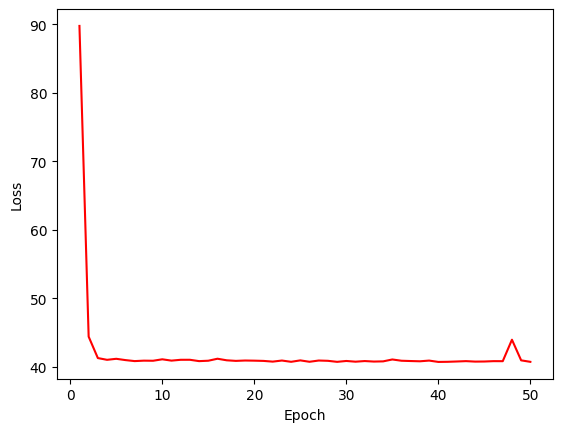

In [14]:
# loss curve
plt.plot(range(1, NUM_EPOCHS+1), loss_trace, 'r-')
#plt.plot(range(1, len(loss_trace)), loss_trace, 'r-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

"Not included is the positioning encoding, which is a critical element of Transformer. Also, the building blocks of nn.Transformer can be decomposed and modified for better performance and more applications. And there are a number of parameters that can be fine-tuned for optimal performance."
